# Определение перспективного тарифа для телеком компании

### Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

#### Описание тарифов

##### Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
- минута разговора: 3 рубля
- сообщение: 3 рубля
- 1 Гб интернет-трафика: 200 рублей

##### Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
- минута разговора: 1 рубль
- сообщение: 1 рубль
- 1 Гб интернет-трафика: 150 рублей

### Описание данных

Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
#Импорт библиотеки
import pandas as pd
import math
import numpy as np
from scipy import stats as st
import seaborn as sns

In [2]:
#Считаем датасеты
df_calls = pd.read_csv('/datasets/calls.csv', index_col=0).reset_index()
df_internet = pd.read_csv('/datasets/internet.csv', index_col=0).reset_index()
df_messages = pd.read_csv('/datasets/messages.csv', index_col=0).reset_index()
df_tariffs = pd.read_csv('/datasets/tariffs.csv', index_col=0).reset_index()
df_users = pd.read_csv('/datasets/users.csv', index_col=0).reset_index()

In [3]:
# Поочередно изучим информацию о датасетах
df_calls.info()
df_calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


##### По повторяющимся user_id видно, что один и тот же пользователь совершал несколько звонков

In [4]:
#Посмотрим датасет с информацией об используемом интернете
df_internet.info()
df_internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
index           149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,index,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [5]:
#Посмотрим датасет с информацией об смс
df_messages.info()
df_messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [6]:
df_messages.columns

Index(['id', 'message_date', 'user_id'], dtype='object')

In [7]:
#Посмотрим датасет с информацией о тарифах
df_tariffs.info()
df_tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
#Посмотрим датасет с информацией об используемом интернете
df_users.info()
df_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


### Шаг 2. Подготовьте данные

##### 1) Приведите данные к нужным типам

In [9]:
# Для удобства поменяем тип данных call_date в datetime
try:
    df_calls['call_date'] = pd.to_datetime(df_calls['call_date'],format='%Y-%m-%d')
except:
        print('Ошибка при переводe')

In [10]:
# Для удобства поменяем тип данных session_date в datetime
try:
    df_internet['session_date'] = pd.to_datetime(df_internet['session_date'],format='%Y-%m-%d')
except:
        print('Ошибка при переводe')

In [11]:
# Для удобства поменяем тип данных message_date в datetime
try:
    df_messages['message_date'] = pd.to_datetime(df_messages['message_date'],format='%Y-%m-%d')
except:
        print('Ошибка при переводe')

In [12]:
# Для удобства поменяем тип данных churn_date и reg_dateв datetime
try:
    df_users['churn_date'] = pd.to_datetime(df_users['churn_date'],format='%Y-%m-%d')

    df_users['reg_date'] = pd.to_datetime(df_users['reg_date'],format='%Y-%m-%d')
except:
        print('Ошибка при переводe')

##### 2) Найдите и исправьте ошибки в данных

In [13]:
# Так как тариф начинает действовать даже при 0 минут звонка и 0 использованных  мегабайт,
#огруглим все в большую сторону
df_calls['duration'] = df_calls['duration'].apply(lambda x: math.ceil(x))
df_internet['mb_used'] = df_internet['mb_used'].apply(lambda x: math.ceil(x))
# Там, где интернет-трафик или звонки имеют нулевое значение, прибавляем 1, так как тариф начал 
df_calls.loc[df_calls['duration'] == 0, 'duration'] = 1
df_internet.loc[df_internet['mb_used'] == 0, 'mb_used'] = 1

#### Звонки длительностью о минут могли возникнуть, когда клиент не дозвонился. Но при этом работа телеком-компанией была проведена (были использованы вышки и т д), соответственно тариф начал действовать. Аналогичная ситуация и с интнернетом. Если пользователю не удалось подключиться, тариф все равно начнет действовать.

#### Подобным образом с огруглением советовал делать и наставник Андрей Сухань на консультации, он работал в Билайне.

In [14]:
#Найдем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя
df_calls['call_date'] = pd.DatetimeIndex(df_calls['call_date']).month
calls_pivot = pd.pivot_table(df_calls, index=['user_id', 'call_date'], values = ['duration'], aggfunc=('sum', 'count')).reset_index()
display(calls_pivot)

user_id call_date duration     
                          count  sum
0       1000         5       22  164
1       1000         6       43  187
2       1000         7       47  346
3       1000         8       52  418
4       1000         9       58  478
...      ...       ...      ...  ...
3169    1498        10       41  258
3170    1499         9        9   71
3171    1499        10       68  473
3172    1499        11       74  624
3173    1499        12       69  505

[3174 rows x 4 columns]

In [15]:
# Переиминуем столбцы
calls_pivot.columns = ['user_id',
            'date',
            ( 'calls_count'),
            ( 'calls_sum')]

In [16]:
# Посчитаем количество отправленных смс по месяцам для каждого пользователя
df_messages['message_date'] = pd.DatetimeIndex(df_messages['message_date']).month
message_pivot = pd.pivot_table(df_messages, index=['user_id', 'message_date'], values = ['id'], aggfunc='count').reset_index()
display(message_pivot)

,user_id,message_date,id
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [17]:
message_pivot.columns = ['user_id', 'date', 'messages_count']

In [18]:
#Переведем Мб в Гб
df_internet['mb_used'] = df_internet['mb_used']/1024
df_internet.columns = ['index', 'id', 'gb_used', 'session_date', 'user_id']

In [19]:
#количество интернет-сессий по месяцам
df_internet['session_date'] = pd.DatetimeIndex(df_internet['session_date']).month
internet_pivot = pd.pivot_table(df_internet, index=['user_id', 'session_date'], values = ['gb_used'], aggfunc='sum').reset_index()
display(internet_pivot)

,user_id,session_date,gb_used
0,1000,5,2.204102
1,1000,6,22.716797
2,1000,7,13.688477
3,1000,8,13.742188
4,1000,9,14.241211
...,...,...,...
3198,1498,10,20.130859
3199,1499,9,1.805664
3200,1499,10,17.406250
3201,1499,11,17.572266


In [20]:
internet_pivot.columns = ['user_id', 'date', 'gb_used']

In [21]:
#Объединим таблицы звонков и смс
df = calls_pivot.merge(message_pivot, on=['user_id', 'date'],  how='outer')

In [22]:
#Объединим полученную таблицу с таблицей использованного интернета
df = df.merge(internet_pivot, on=['user_id', 'date'], how='outer')

In [23]:
#Объединим полученную таблицу с таблицей пользователей
df = df.merge(df_users, on=['user_id'], how='outer')

In [24]:
# В таблице тарифов переведем МБ в ГБ
df_tariffs['mb_per_month_included'] = df_tariffs['mb_per_month_included']/1024
df_tariffs.columns = ['messages_included', 'gb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

In [25]:
#Уберем ненужные для анализа столбцы
df.drop(['age', 'first_name', 'last_name', 'churn_date', 'reg_date'], axis='columns', inplace=True)

In [26]:
#Объединим общую таблицу с информацией по тарифам
df= df.merge(df_tariffs, on=['tariff'],  how='outer')

In [27]:
#заполним пропуски нулями, так как в некоторые месяцы, например, пользователь мог говорить по телефону, но не отправлять смс
columns = ['calls_count', 'calls_sum','messages_count','gb_used']
for col in columns:
     df[col] = df[col].fillna(value='0').astype('int')

In [28]:
#Посчитаем помесячную выручку с каждого пользователя
def monthly_revenue (df):
    call=df['calls_sum']
    mess=df['messages_count']
    inet=df['gb_used']
    abonent =df['rub_monthly_fee']
    
    if (call-df['minutes_included'])>0:
        delta_min=math.ceil((call-df['minutes_included']))*df['rub_per_minute']
    else:
        delta_min=0
        
    if (mess-df['messages_included'])>0:
        delta_mess = (mess-df['messages_included']) * df['rub_per_message']
    else:
        delta_mess=0

    if (inet-df['gb_per_month_included'])>0:
        delta_data = math.ceil(((inet-df['gb_per_month_included'])/1000))*df['rub_per_gb']
        
    else:
        delta_data=0
       
    total = abonent + delta_min + delta_mess + delta_data   

    return total
    
df['rev'] = df.apply(monthly_revenue, axis=1)


In [57]:
df

,user_id,date,calls_count,calls_sum,messages_count,gb_used,city,tariff,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,rev
0,1000,5.0,22,164,22,2,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950
1,1000,6.0,43,187,60,22,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950
2,1000,7.0,47,346,75,13,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950
3,1000,8.0,52,418,81,13,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950
4,1000,9.0,58,478,57,14,Краснодар,ultra,1000,30.0,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9.0,0,0,32,16,Санкт-Петербург,smart,50,15.0,500,550,200,3,3,750
3212,1489,10.0,0,0,21,19,Санкт-Петербург,smart,50,15.0,500,550,200,3,3,750
3213,1489,11.0,0,0,20,17,Санкт-Петербург,smart,50,15.0,500,550,200,3,3,750
3214,1489,12.0,0,0,35,16,Санкт-Петербург,smart,50,15.0,500,550,200,3,3,750


#### Шаг 3. Проанализируйте данные

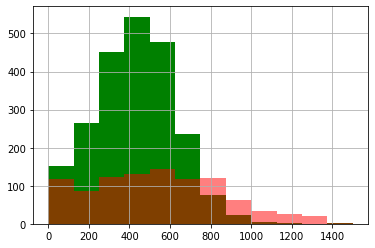

In [29]:
#Посмотрим зависимости количества минут разговора по месяцам и тарифам
df_smart = df.query('tariff == "smart"')
df_ultra = df.query('tariff == "ultra"')
#Построим гистограммы
df_smart['calls_sum'].hist(color= 'g', range = (0,1500), bins = 12)
df_ultra['calls_sum'].hist(alpha = 0.5, color= 'r', range = (0,1500), bins = 12)

#### Чаще всего на тарифе смарт пользователи тратят примерно 400-500 минут в месяц, а пользователи тарифа ультра в широком диапазоне от 0 до 900 минут.

In [30]:
#Посчитаем среднее для количества минут разговора по месяца
calls_mean = df.pivot_table(index='date', columns = 'tariff', values='calls_sum', aggfunc = 'mean').reset_index()
calls_mean 

tariff,date,smart,ultra
0,1.0,209.647059,440.888889
1,2.0,306.310345,304.666667
2,3.0,400.532468,503.081081
3,4.0,377.000000,470.072727
4,5.0,398.404255,524.865672
5,6.0,406.701220,492.428571
6,7.0,419.288557,560.296703
7,8.0,433.191489,524.570093
8,9.0,440.080769,553.643478
9,10.0,438.295918,572.829268


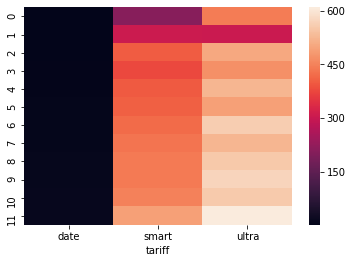

In [31]:
#Визуализируем
sns.heatmap(calls_mean)

#### Видно, что в среднем пользователи тарифа ультра больше говорят по телефону, примерно минут на 100 в месяц,исключение в январе, когдп пользователи обоих тарифов говорили примерно поровну.

In [32]:
#Посчитаем дисперсию для количества минут разговора по месяца
calls_var = df.pivot_table(index='date', columns = 'tariff', values='calls_sum', aggfunc=(lambda x: round(np.var(x),2))).reset_index()
calls_var

tariff,date,smart,ultra
0,1.0,24497.05,69675.21
1,2.0,37374.28,88728.47
2,3.0,38023.29,113935.91
3,4.0,36194.18,73899.78
4,5.0,36100.72,87125.19
5,6.0,31959.93,94514.84
6,7.0,33689.66,98493.11
7,8.0,36305.92,102010.96
8,9.0,35061.90,109853.64
9,10.0,36923.65,111279.44


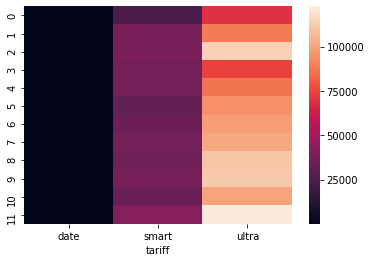

In [33]:
#Визуализируем
sns.heatmap(calls_var)

In [34]:
#Посчитаем стандартное отклонение для количества минут разговора по месяца
calls_std = df.pivot_table(index='date', columns = 'tariff', values='calls_sum', aggfunc=(lambda x: round(np.std(x),2))).reset_index()
calls_std

tariff,date,smart,ultra
0,1.0,156.52,263.96
1,2.0,193.32,297.87
2,3.0,195.00,337.54
3,4.0,190.25,271.85
4,5.0,190.00,295.17
5,6.0,178.77,307.43
6,7.0,183.55,313.84
7,8.0,190.54,319.39
8,9.0,187.25,331.44
9,10.0,192.16,333.59


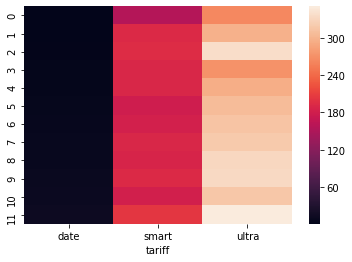

In [35]:
#Визуализируем
sns.heatmap(calls_std)

<font color=green> Столбец с датой нам по большому счету не нужен. Его можно убрать. 
    
---

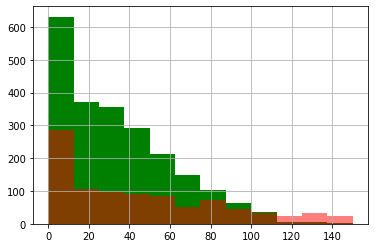

In [36]:
#Построим гистограммы для количества отправленных смс по тарифам
df_smart['messages_count'].hist(color= 'g', range = (0,150), bins = 12)
df_ultra['messages_count'].hist(alpha = 0.5, color= 'r', range = (0,150), bins = 12)

##### Хвост гистограммы тарифа Ультра идет больше 110 минут.

In [37]:
#Посчитаем среднее для количества смс по месяца
messages_mean = df.pivot_table(index='date', columns = 'tariff', values='messages_count', aggfunc = 'mean').reset_index()
messages_mean 

tariff,date,smart,ultra
0,1.0,18.235294,33.777778
1,2.0,24.086207,21.958333
2,3.0,31.857143,32.297297
3,4.0,30.741071,31.563636
4,5.0,33.773050,37.850746
5,6.0,33.402439,41.726190
6,7.0,33.751244,49.846154
7,8.0,33.638298,48.439252
8,9.0,33.638462,52.286957
9,10.0,33.765306,58.430894


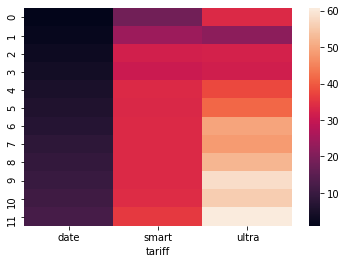

In [38]:
#Визуализируем
sns.heatmap(messages_mean)

#### В начале года пользователи тарифов смарт и ультра в среднем отправляли одинаковое количество смс в день. Начиная с апреля отрыв пользователей тарифа Ультра начал увеличиваться вплоть до 25 смс больше в месяц в среднем.

In [39]:
#Посчитаем дисперсию для количества смс по месяца
messages_np = df.pivot_table(index='date', columns = 'tariff', values='messages_count', aggfunc=(lambda x: round(np.var(x),2))).reset_index()
messages_np

tariff,date,smart,ultra
0,1.0,254.65,836.17
1,2.0,464.94,686.96
2,3.0,709.16,1685.56
3,4.0,596.76,1381.70
4,5.0,725.81,1600.40
5,6.0,801.89,1962.65
6,7.0,795.91,2345.98
7,8.0,834.69,2151.44
8,9.0,787.58,2134.14
9,10.0,813.34,2675.25


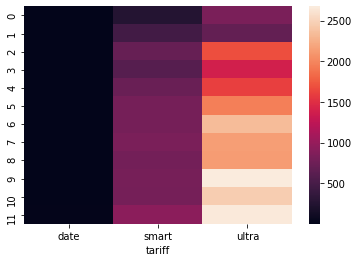

In [40]:
#Визуализируем
sns.heatmap(messages_np)

In [41]:
#Посчитаем стандартное отклонение для количества смс по месяца
messages_std = df.pivot_table(index='date', columns = 'tariff', values='messages_count', aggfunc=(lambda x: round(np.std(x),2))).reset_index()
messages_std

tariff,date,smart,ultra
0,1.0,15.96,28.92
1,2.0,21.56,26.21
2,3.0,26.63,41.06
3,4.0,24.43,37.17
4,5.0,26.94,40.00
5,6.0,28.32,44.30
6,7.0,28.21,48.44
7,8.0,28.89,46.38
8,9.0,28.06,46.20
9,10.0,28.52,51.72


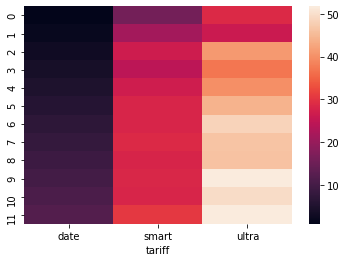

In [42]:
#Визуализируем
sns.heatmap(messages_std)

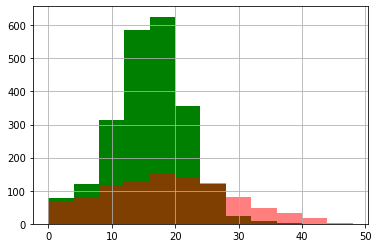

In [43]:
#Построим гистограммы количества используемых Гб в месяц по тарифам
df_smart['gb_used'].hist(color= 'g', range = (0,48), bins = 12)
df_ultra['gb_used'].hist(alpha = 0.5, color= 'r', range = (0,48), bins = 12)

In [44]:
#Посчитаем среднее количство Гб в месяц
internet_mean = df.pivot_table(index='date', columns = 'tariff', values='gb_used', aggfunc= 'mean').reset_index()
internet_mean

tariff,date,smart,ultra
0,1.0,7.735294,12.333333
1,2.0,10.862069,11.083333
2,3.0,14.246753,16.702703
3,4.0,12.651786,16.000000
4,5.0,14.950355,18.462687
5,6.0,14.987805,17.976190
6,7.0,14.920398,19.549451
7,8.0,15.791489,18.644860
8,9.0,15.430769,18.260870
9,10.0,15.925170,19.097561


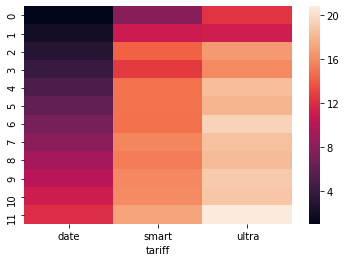

In [45]:
#Визуализируем
sns.heatmap(internet_mean)

##### В среднем пользователи тарифа ультра используют на 2-4 Гб в месяц. При чем среднее количепство Гб растет к конце года.

In [46]:
#Посчитаем дисперсию для использованных Гб по месяца
internet_var = df.pivot_table(index='date', columns = 'tariff', values='gb_used', aggfunc=(lambda x: round(np.var(x),2))).reset_index()
internet_var

tariff,date,smart,ultra
0,1.0,38.25,40.89
1,2.0,36.57,102.66
2,3.0,32.11,112.32
3,4.0,30.80,87.49
4,5.0,34.63,94.34
5,6.0,32.00,81.26
6,7.0,33.33,95.52
7,8.0,30.01,103.59
8,9.0,26.05,85.11
9,10.0,32.97,90.59


In [47]:
#Посчитаем стандартное отклонение для количества использованных ГБ по месяца
internet_std = df.pivot_table(index='date', columns = 'tariff', values='gb_used', aggfunc=(lambda x: round(np.std(x),2))).reset_index()
internet_std

tariff,date,smart,ultra
0,1.0,6.18,6.39
1,2.0,6.05,10.13
2,3.0,5.67,10.60
3,4.0,5.55,9.35
4,5.0,5.88,9.71
5,6.0,5.66,9.01
6,7.0,5.77,9.77
7,8.0,5.48,10.18
8,9.0,5.10,9.23
9,10.0,5.74,9.52


In [48]:
df['rev'].describe()

count    3216.000000
mean     1165.777363
std       592.724818
min       550.000000
25%       682.000000
50%       846.000000
75%      1950.000000
max      3705.000000
Name: rev, dtype: float64

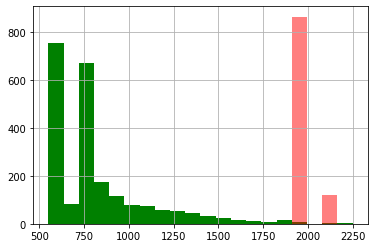

In [49]:
#Дополнительно построим гистограммы стоимости в месяц по тарифам
df_smart['rev'].hist(color= 'g', range = (550,2250), bins = 20)
df_ultra['rev'].hist(alpha = 0.5, color= 'r', range = (550,2250), bins = 20)

In [50]:
#Изучим среднюю стоимость по месяцам
rev_mean = df.pivot_table(index='date', columns = 'tariff', values='rev', aggfunc= 'mean').reset_index()
rev_mean

tariff,date,smart,ultra
0,1.0,588.058824,1950.000000
1,2.0,648.844828,1962.500000
2,3.0,768.181818,1962.162162
3,4.0,726.660714,1960.909091
4,5.0,760.950355,1963.432836
5,6.0,766.829268,1964.285714
6,7.0,781.796020,1973.076923
7,8.0,816.761702,1972.429907
8,9.0,808.346154,1966.956522
9,10.0,831.010204,1968.292683


##### Пользователи тарифа Ультра в среднем немного превышают свой тариф за 1950. Пользователи тарифа Смарт чаще превышают свой лимит за 550 р в среднем на 250р.

#### Шаг 4. Проверьте гипотезы

##### 1) средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [51]:
#Сделаем выборки по тарифам
df_smart = df.query('tariff == "smart"')
df_ultra = df.query('tariff == "ultra"')

##### Проверим гипотезу о равенстве средней выручки пользователей тарифов «Ультра» и «Смарт» 
##### Критический уровень статистической значимости зададим значение 0.05.

In [52]:
alpha = 0.05 # ваш код: задайте критический уровень статистической значимости

results = st.ttest_ind(
    df_smart['rev'], 
    df_ultra['rev'])
# ваш код: проверьте гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


#### Выручка по тарифам отличается

##### 2) средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [53]:
#Начнем с формирования двух массивов со средними выручками по городам
rev_moscow = df.query('city == "Москва"')
rev_other = df.query('city != "Москва"')

##### Проверим гипотезу о равенстве средней выручки пользователей из Москвы и других городов
##### Критический уровень статистической значимости зададим значение 0.05.

In [54]:
alpha = 0.05 # ваш код: задайте критический уровень статистической значимости

results = st.ttest_ind(
    rev_moscow['rev'], 
    rev_other['rev'])
# ваш код: проверьте гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.004807736166322075
Отвергаем нулевую гипотезу


##### Выручка по Москве и другим городам отличается

### Вывод

#### Были представлены датасеты и информацией о пользователях сотовой связи, потраченных ими минутах на разговоры по мобильному телефону, использованному интернету и отправленных смс, о тарифах, которые они используют.

#### Датасеты были проверены на ошибки и пропуски. Если у пользователя значилось 0 минут нразговора или 0 Мб интернета, то шло округление в большую сторону до единицы, так как тариф все равно был подключен

#### На этапе подготовки данных были посчитаны
 - количество сделанных звонков и израсходованных минут разговора по месяцам;
 - количество отправленных сообщений по месяцам;
 - объем израсходованного интернет-трафика по месяцам;

#### Анализ показал, что
- Чаще всего на тарифе смарт пользователи тратят примерно 400-500 минут в месяц, а пользователи тарифа ультра в широком диапазоне от 0 до 900 минут.Видно, что в среднем пользователи тарифа ультра больше говорят по телефону, примерно минут на 100 в месяц,исключение в январе, когдп пользователи обоих тарифов говорили примерно поровну.
- Хвост гистограммы тарифа Ультра идет больше 110 минут. Пользователи тарифа смарт чаще всего отправляют около 40 смс в месяц, а пользователи тарифа ультра больше 45. В начале года пользователи тарифов смарт и ультра в среднем отправляли одинаковое количество смс в день. Начиная с апреля отрыв пользователей тарифа Ультра начал увеличиваться вплоть до 25 смс больше в месяц в среднем.
- В среднем пользователи тарифа ультра используют на 2-4 Гб в месяц. При чем среднее количепство Гб растет к конце года.Пользователи тарифа ультра используют в среднем на 1.5ГБ в месяц больше, чем пользователи тарифа смарт. Пользователи тарифа смартчаще всего используют 15,5 Гб в месяц, а пользователи тарифа ультра 19Гб.
- Пользователи тарифа Ультра в среднем немного превышают свой тариф за 1950. Пользователи тарифа Смарт чаще превышают свой лимит за 550 р в среднем на 250р.

####  Были посчитаны среднее количество, дисперсию и стандартное отклонение для звонков, смс и интернета. В среднем дисперсия и среднее отклонение по всем эти показателям для пользователей тарифа Ультра выше.

#### Были выдвинуты гипотезы :
- о равенстве средней выручки пользователей тарифов «Ультра» и «Смарт»
- о равенстве средней выручки пользователей услугами сотовой связи  из Москвы и других городов

#### Обе гипотезы были отвергнуты после p-value тестирования

#### Пользователи, которые используют тариф Ультра, выгоднее обходятся компании, так как стоимость их тарифа больше чем в 3 раза выше стоимости тарифа Смарт, а звонков и смс они в основном тратят значительно ниже лимита. При этом, судя по итоговой стоимости,  в среднем пользователи тарифа Ультра могут немного превышать свой лимит в месяц.